In [43]:
import sys

import pandas as pd
import numpy as np

import xgboost as xgb

from pylightgbm.models import GBMRegressor

from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, train_test_split

from sklearn.linear_model import LinearRegression

from hyperopt import fmin, tpe, hp, Trials

Используемые модели

1. XGB, много признаков. LB 1111.5
2. XGB, много признаков, fair objective. LB 1107
3. Keras, baseline с форума. LB 1112


In [45]:
df = pd.read_csv('../raw_data/train.csv')
df_test = pd.read_csv('../raw_data/test.csv')

xgb_oob = pd.read_csv('../run_res/feat_xgb_bag_oob.csv')
xgb_oob_2 = pd.read_csv('../run_res/feat_xgb_bag_oob_2.csv')
xgb_oob_3 = pd.read_csv('../run_res/feat_xgb_bag_oob_3.csv')
xgb_oob_4 = pd.read_csv('../run_res/feat_xgb_bag_oob_4.csv')
lgbm_oob = pd.read_csv('../run_res/feat_lgbm_bag_oob_1.csv')
vw_oob = pd.read_csv('../run_res/vw_oob_train.csv')
keras_oob = pd.read_csv('../run_res/keras_oob.csv')
keras_oob = keras_oob.sort_values(['id'])

xgb = pd.read_csv('../submissions/feat_xgb_bag.csv')
xgb_2 = pd.read_csv('../submissions/feat_xgb_bag_2.csv')
xgb_3 = pd.read_csv('../submissions/feat_xgb_bag_3.csv')
xgb_4 = pd.read_csv('../submissions/feat_xgb_bag_4.csv')
xgb_4_ub = pd.read_csv('../submissions/12_12_feat_xgb_unbagged.csv')
lgbm = pd.read_csv('../submissions/feat_lgbm_bag_1.csv')
keras = pd.read_csv('../submissions/submission_keras_shift_perm.csv')

y_true = df.loss

## Single model weight tuning

In [138]:
weights = [1.000, 1.005, 1.010, 1.012, 1.015, 1.017, 1.020, 1.025]
for w in weights:
    print w, mean_absolute_error(y_true, xgb_oob.loss * w)

1.0 1132.72564123
1.005 1132.355411
1.01 1132.10136341
1.012 1132.03338538
1.015 1131.96808649
1.017 1131.94949788
1.02 1131.95681427
1.025 1132.06056853


Модель, которую учили на fair objective дает несмещенную оценку. Однако, как мы успели выяснить, в поиске весов с помощью hyperopt это не дало преимущество

In [139]:
weights = [1.000, 1.005, 1.010, 1.012, 1.015, 1.017, 1.020, 1.025]
for w in weights:
    print w, mean_absolute_error(y_true, xgb_oob_2.loss * w)

1.0 1130.67230189
1.005 1130.57035767
1.01 1130.5918462
1.012 1130.63304388
1.015 1130.72970727
1.017 1130.81489397
1.02 1130.97664542
1.025 1131.33752149


In [140]:
weights = [1.000, 1.005, 1.010, 1.012, 1.015, 1.017, 1.020, 1.025, 1.030]
for w in weights:
    print w, mean_absolute_error(y_true, keras_oob.loss * w)

1.0 1130.93285255
1.005 1130.40568593
1.01 1129.99481504
1.012 1129.86228187
1.015 1129.69867339
1.017 1129.61164012
1.02 1129.51551309
1.025 1129.45060951
1.03 1129.50693932


In [345]:
weights = [1.000, 1.005, 1.010, 1.012, 1.015, 1.017, 1.020, 1.025, 1.030]
for w in weights:
    print w, mean_absolute_error(y_true, lgbm_oob.loss * w)

1.0 1133.8736824
1.005 1133.53344987
1.01 1133.30421409
1.012 1133.245285
1.015 1133.19264291
1.017 1133.1812708
1.02 1133.19571712
1.025 1133.30727431
1.03 1133.52470141


## Отправим среднее, скорректированное на смещение

In [47]:
new = keras.copy()

In [62]:
new['loss'] = keras['loss'] * 0.5 * 1.025 + xgb['loss'] * 0.5 * 1.017

In [63]:
new.to_csv('../submissions/12_1_keras_and_xgb_05_2.csv', index=False)

Public LB - 1103.8

## Подберем параметры модели с помощью Hyperopt

In [126]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [353]:
space = {
    'a': hp.normal('a', 0, 200),
    'b1': hp.normal('b1', 0.5, 0.1),
    'b2': hp.normal('b2', 0.5, 0.1)
}

In [144]:
def stack_lin(params):
    a = params['a']
    b1 = params['b1']
    b2 = params['b2']
    
    return mean_absolute_error(
        y_true,
        a + xgb_oob.loss.values * b1 + keras_oob.loss.values * b2
    )

In [145]:
trials = Trials()

In [146]:
fmin(
    fn=stack_lin,
    space=space,
    algo=tpe.suggest,
    max_evals=400,
    trials=trials
)

{'a': -72.239753296384, 'b1': 0.5054321189391783, 'b2': 0.5442627701332745}

In [ ]:
new['loss'] = keras.loss * 0.5442627701332745 + xgb.loss * 0.5054321189391783 - 72.239753296384

In [ ]:
new.to_csv('../submissions/12_1_keras_and_xgb_fmin.csv', index=False)

LB 1103.2

In [370]:
def stack_lin(params):
    a = params['a']
    b1 = params['b1']
    b2 = params['b2']
    
    return mean_absolute_error(
        y_true,
        a + xgb_oob_2.loss.values * b1 + keras_oob.loss.values * b2
    )

In [289]:
trials = Trials()

In [290]:
fmin(
    fn=stack_lin,
    space=space,
    algo=tpe.suggest,
    max_evals=5000,
    trials=trials
)

{'a': -38.65751977389668, 'b1': 0.5012842079976433, 'b2': 0.5302852035137959}

In [371]:
stack_lin({'a': -21.782875204319453, 'b1': 0.4885732254348957, 'b2': 0.5357543465564601})

1120.9175999882777

In [173]:
new['loss'] = keras.loss * 0.5357543465564601 + xgb_2.loss * 0.4885732254348957 - 21.782875204319453
new.to_csv('../submissions/12_2_keras_and_xgb_fmin_2.csv', index=False)

LB 1102.8

In [355]:
def stack_lin(params):
    a = params['a']
    b1 = params['b1']
    b2 = params['b2']
    
    return mean_absolute_error(
        y_true,
        a + xgb_oob_4.loss.values * b1 + keras_oob.loss.values * b2
    )

In [360]:
trials = Trials()

In [361]:
fmin(
    fn=stack_lin,
    space=space,
    algo=tpe.suggest,
    max_evals=5000,
    trials=trials
)

{'a': -51.71789861212561, 'b1': 0.6033401002422197, 'b2': 0.43307485493869324}

In [376]:
stack_lin({'a': -53.9048173779142, 'b1': 0.6451223116952068, 'b2': 0.38866552887318534})

1121.2924697143901

Error gives a boost =)

In [374]:
new['loss'] = keras.loss * 0.38866552887318534 + xgb_3.loss * 0.6451223116952068 - 53.9048173779142
new.to_csv('../submissions/12_11_keras_and_xgb_fmin.csv', index=False)

LB 1102.38

In [48]:
new['loss'] = keras.loss * 0.38866552887318534 + xgb_4_ub.loss * 0.6451223116952068 - 53.9048173779142
new.to_csv('../submissions/12_12_keras_and_xgb_ub.csv', index=False)

In [363]:
space = {
    'a': hp.normal('a', 0, 50),
    'b1': hp.normal('b1', 0.7, 0.05),
    'b2': hp.normal('b2', 0.15, 0.05),
    'b3': hp.normal('b3', 0.15, 0.05),
}

In [51]:
def stack_lin(params):
    a = params['a']
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    
    return mean_absolute_error(
        y_true,
        a + xgb_oob_4.loss.values * b1 + keras_oob.loss.values * b2 + lgbm_oob.loss.values * b3
    )

In [365]:
trials = Trials()

In [366]:
best = fmin(
    fn=stack_lin,
    space=space,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

In [367]:
best

{'a': -57.361560020671625,
 'b1': 0.5302617790461561,
 'b2': 0.41932675364098726,
 'b3': 0.08812000286803214}

In [49]:
best = {'a': -57.361560020671625,
 'b1': 0.5302617790461561,
 'b2': 0.41932675364098726,
 'b3': 0.08812000286803214}

In [52]:
stack_lin(best)

1119.4703989679722

In [74]:
cv = KFold(n_splits=5, shuffle=True, random_state=2016)
X = pd.DataFrame({'xgb': xgb_oob_4.loss.values, 'keras': keras_oob.loss.values, 'lgbm': lgbm_oob.loss.values})

In [75]:
space = {
    'a': hp.normal('a', 0, 50),
    'b1': hp.normal('b1', 0.5, 0.1),
    'b2': hp.normal('b2', 0.5, 0.1),
    'b3': hp.normal('b3', 0.15, 0.05),
}

bests = []

for train, val in cv.split(X):
    
    X_train = X.iloc[train, :]
    X_val = X.iloc[val, :]
    y_train = y_true[train]
    y_val = y_true[val]
    
    def stack_lin(params):
        a = params['a']
        b1 = params['b1']
        b2 = params['b2']
        b3 = params['b3']
        
        return mean_absolute_error(
            y_train,
            a + X_train.xgb.values * b1 + X_train.keras.values * b2 + X_train.lgbm.values * b3
        )
    
    def stack_lin_val(params):
        a = params['a']
        b1 = params['b1']
        b2 = params['b2']
        b3 = params['b3']

        return mean_absolute_error(
            y_val,
            a + X_val.xgb.values * b1 + X_val.keras.values * b2 + X_val.lgbm.values * b3
        )
    
    trials = Trials()
    
    best = fmin(
        fn=stack_lin,
        space=space,
        algo=tpe.suggest,
        max_evals=500,
        trials=trials
    )
    
    bests.append(best)
    
    print 'Train MAE = {:.2f}'.format(stack_lin(best))
    print 'Val MAE = {:.2f}'.format(stack_lin_val(best))
    
#     print 'Train MAE = {:.2f}'.format(stack_lin(best))

Train MAE = 1119.76
Val MAE = 1118.43
Train MAE = 1120.73
Val MAE = 1114.25
Train MAE = 1119.59
Val MAE = 1118.88
Train MAE = 1118.25
Val MAE = 1124.35
Train MAE = 1118.86
Val MAE = 1121.66


In [81]:
best = pd.DataFrame(bests).mean().to_dict()

In [83]:
best

{'a': -57.754799516213623,
 'b1': 0.45881800465856004,
 'b2': 0.41931244038393689,
 'b3': 0.1622399879004312}

In [82]:
new['loss'] = xgb_4.loss * best['b1'] + keras.loss * best['b2'] + lgbm.loss * best['b3'] + best['a']
new.to_csv('../submissions/12_12_keras_lgbm_and_xgb_ub.csv', index=False)

In [346]:
foo = keras.loss * 0.52555598735069681 + xgb_3.loss * 0.50845475778486 - 42.88560549305209

In [348]:
new['loss'] = foo * 0.8 + lgbm.loss * 0.2 * 1.02
new.to_csv('../submissions/12_9_keras_lgbm_and_xgb_fmin_2.csv', index=False)

## MCMC

In [14]:
from pymc3 import *

In [19]:
size = 200
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
model1 = true_regression_line + np.random.normal(scale=.5, size=size) #Noisy
model2 = true_regression_line + np.random.normal(scale=.2, size=size) #Less Noisy

In [35]:
data = dict(
    x1=np.log(xgb_oob_4.loss.values)+200,
    x2=np.log(keras_oob.loss.values)+200,
#     x3=lgbm_oob.loss.values,
    y=np.log(y_true.values)+200)

In [26]:
data = dict(x1=model1, x2=model2, y=true_regression_line)

In [32]:
start = {'Intercept': 0, 'x1': 0.5, 'x2': 0.5}

In [41]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x1 + x2', data)
    step = NUTS() # Instantiate MCMC sampling algorithm
    trace = sample(1000, step, progressbar=True)

100%|██████████| 1000/1000 [00:07<00:00, 142.45it/s]


ValueError: v cannot be empty

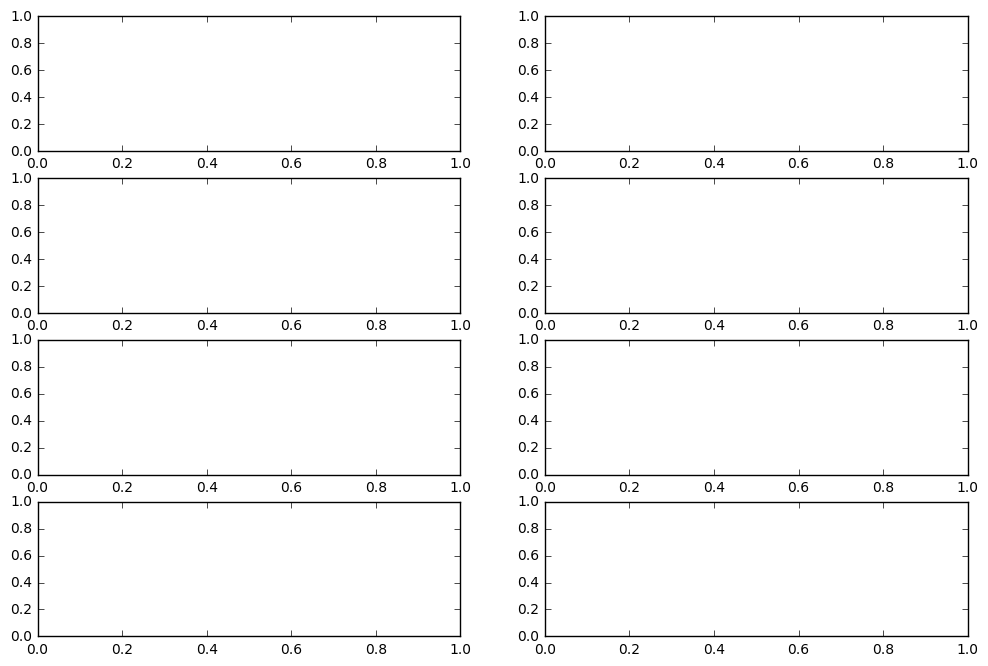

In [42]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

In [39]:
np.median(trace.x1)

0.4976200940274304

In [40]:
np.median(trace.x2)

0.50236434848300282

## Elastic Net

In [85]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, KFold

In [86]:
en = ElasticNet(alpha=1, l1_ratio=0)

In [150]:
X = xgb_oob_2.copy()
X['xgb'] = X['loss']
X['keras'] = keras_oob['loss'].values
X.drop(['loss'], 1, inplace=True)

In [151]:
X.head()

,id,xgb,keras
0,1,2025.304932,1802.697144
1,2,1707.920410,1462.424329
2,5,4328.561035,3971.401782
3,10,1121.829956,975.925171
4,11,2922.152588,3152.145312


In [152]:
y_true.head()

0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64

In [155]:
cv = KFold(n_splits=3, shuffle=True, random_state=2016)

In [100]:
en = ElasticNet(alpha=0, l1_ratio=0)

In [103]:
for train, test in cv.split(X):
    xtrain = X.iloc[train, :]
    xtest = X.iloc[test, :]
    ytrain = y_true.iloc[train]
    ytest =  y_true.iloc[test]
    en = ElasticNet(alpha=0, l1_ratio=0, warm_start=True)
    en.coef_ = np.array([0.45881800465856004, 0.41931244038393689, 0.1622399879004312])
    en.intercept_ = -57.754799516213623
    en.fit(xtrain, ytrain)
    print mean_absolute_error(en.predict(xtrain), ytrain)
    print mean_absolute_error(en.predict(xtest), ytest)

/home/ledovsky/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


1149.43435725
1147.93380909
1149.94215029
1143.26954362
1148.82200132
1148.96563786
1147.11613251
1154.26022729
1148.60741388
1149.59111876


In [96]:
en.coef_ = np.array([0.45881800465856004, 0.41931244038393689, 0.1622399879004312])

In [95]:
en.intercept_ = -57.754799516213623

In [ ]:
en.set_params()

## Попробуем коррекцию больших ошибок

In [226]:
stacked_oob = keras_oob.loss.values * 0.5357543465564601 + xgb_oob_2.loss * 0.4885732254348957 - 21.782875204319453

In [177]:
mean_absolute_error(stacked_oob, y_true)

1120.9737153156284

In [280]:
def correct_high(params):
#     threshold = params['threshold']
    coef = params['coef']

    return mean_absolute_error(
        y_true,
        stacked_oob * np.where((stacked_oob >= 3000) * (stacked_oob <= 100000), (1 + coef), 1)
    )

In [281]:
space = {
#     'threshold': hp.quniform('threshold', 3000, 20000, 1000),
    'coef': hp.normal('coef', 0, 0.05)
}

In [282]:
trials = Trials()

In [283]:
fmin(
    fn=correct_high,
    space=space,
    algo=tpe.suggest,
    max_evals=400,
    trials=trials
)

{'coef': 0.004778480549055375}

In [284]:
correct_high({'coef': 0.004778480549055375})

1120.9346065520747

In [274]:
np.sum((stacked_oob >= 300) * (stacked_oob <= 1000))

16862

In [230]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   4.90000000e+01,   4.15000000e+02,
          4.16200000e+03,   1.41060000e+04,   2.57740000e+04,
          3.20560000e+04,   3.01290000e+04,   2.49270000e+04,
          1.99860000e+04,   1.51370000e+04,   1.06410000e+04,
          6.33200000e+03,   3.03600000e+03,   1.17000000e+03,
          3.14000000e+02,   6.00000000e+01,   1.80000000e+01,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 204.        ,  204.26666667,  204.53333333,  204.8       ,
         205.06666667,  205.33333333,  205.6       ,  205.86666667,
         206.13333333,  206.4       ,  206.66666667,  206.93333333,
         207.2       ,  207.46666667,  207.73333333,  208.        ,
         208.26666667,  208.53333333,  208.8       ,  209.06666667,
         209.33333333,  209.6       , 

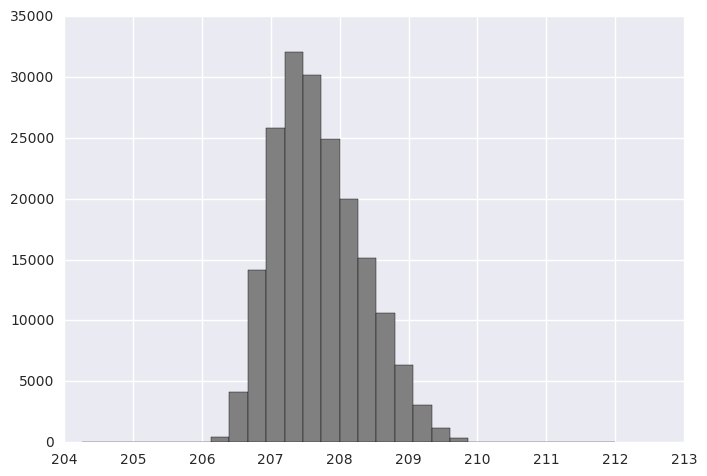

In [240]:
plt.hist((np.log(stacked_oob) + 200), 30, range=[204, 212], facecolor='gray', align='mid')

In [256]:
np.exp(206 - 200)

403.42879349273511

In [257]:
np.exp(207 - 200)

1096.6331584284585

In [218]:
error = np.abs(y_true - stacked_oob)

(array([  1.20000000e+01,   2.40000000e+01,   3.00000000e+01,
          5.70000000e+01,   1.07000000e+02,   2.73000000e+02,
          8.26000000e+02,   1.93800000e+03,   5.32100000e+03,
          1.09500000e+04,   1.62160000e+04,   1.94790000e+04,
          2.23140000e+04,   2.31290000e+04,   2.17570000e+04,
          1.92980000e+04,   1.65910000e+04,   1.26120000e+04,
          8.37200000e+03,   4.98200000e+03,   2.50200000e+03,
          1.00400000e+03,   3.58000000e+02,   1.05000000e+02,
          2.50000000e+01,   1.10000000e+01,   4.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00]),
 array([ 204.        ,  204.26666667,  204.53333333,  204.8       ,
         205.06666667,  205.33333333,  205.6       ,  205.86666667,
         206.13333333,  206.4       ,  206.66666667,  206.93333333,
         207.2       ,  207.46666667,  207.73333333,  208.        ,
         208.26666667,  208.53333333,  208.8       ,  209.06666667,
         209.33333333,  209.6       , 

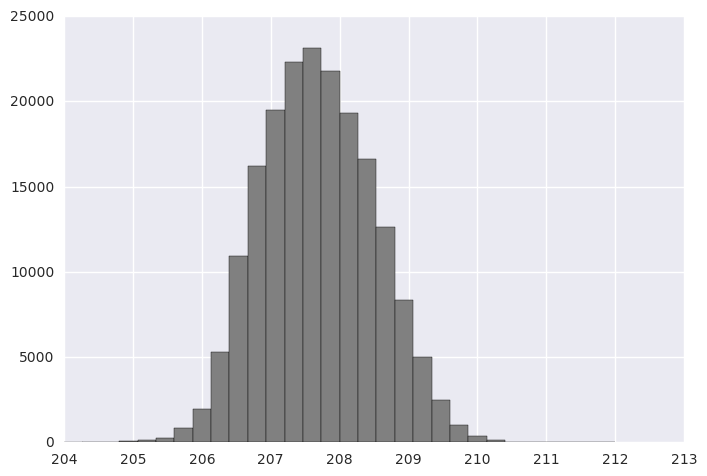

In [238]:
plt.hist((np.log(y_true) + 200), 30, range=[204, 212], facecolor='gray', align='mid')